In [ ]:
from google.colab import drive
# TODO check path
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import random
import matplotlib.pyplot as plt
import numpy as np

import math
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split,ConcatDataset
from torchvision.datasets import ImageFolder

from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import pdb
import math
import collections
torch.cuda.is_available()

True

In [ ]:
from torchvision.transforms.transforms import Resize
# Ref to: https://github.com/thulas/dac-label-noise/blob/master/dac_loss.py
# import torch
# from torch.autograd import Variable
# import torch.nn.functional as F
# from torch.nn.modules.loss import _Loss
# import pdb
# import math

# for numerical stability
epsilon = 1e-7

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG16_upd': [64, ('D', 0.3), 64, 'M', 128, ('D', 0.4), 128, 'M', 256, ('D', 0.4), 256, ('D', 0.4), 256, 'M', 512,
                  ('D', 0.4), 512, ('D', 0.4), 512, 'M', 512, ('D', 0.4), 512, ('D', 0.4), 512, 'M', ('D', 0.5), ],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

# loss calculation and alpha-ramping are rolled into one function. This is invoked
# after every iteration
class dac_loss(_Loss):
    def __init__(self, model, learn_epochs, total_epochs, use_cuda=False, cuda_device=None,
                 alpha_final=1.0, alpha_init_factor=64.):
        print("using dac loss function\n")
        super(dac_loss, self).__init__()
        self.model = model
        self.learn_epochs = learn_epochs
        self.total_epochs = total_epochs
        self.alpha_final = alpha_final
        self.alpha_init_factor = alpha_init_factor
        self.use_cuda = use_cuda
        self.cuda_device = cuda_device

        self.alpha_var = None

        self.alpha_thresh_ewma = None  # exponentially weighted moving average for alpha_thresh
        self.alpha_thresh = None  # instantaneous alpha_thresh
        self.ewma_mu = 0.05  # mu parameter for EWMA;
        self.curr_alpha_factor = None  # for alpha initiliazation
        self.alpha_inc = None  # linear increase factor of alpha during abstention phase
        self.alpha_set_epoch = None

    def __call__(self, input_batch, target_batch, epoch):
        if epoch <= self.learn_epochs or not self.model.training:

            loss = F.cross_entropy(input_batch, target_batch, reduction='none')
            # return loss.mean()
            if self.model.training:
                h_c = F.cross_entropy(input_batch[:, 0:-1], target_batch, reduction='none')
                p_out = torch.exp(F.log_softmax(input_batch, dim=1))
                p_out_abstain = p_out[:, -1]

                # update instantaneous alpha_thresh
                self.alpha_thresh = Variable(((1. - p_out_abstain) * h_c).mean().data)
                # update alpha_thresh_ewma
                if self.alpha_thresh_ewma is None:
                    self.alpha_thresh_ewma = self.alpha_thresh  # Variable(((1. - p_out_abstain)*h_c).mean().data)
                else:
                    self.alpha_thresh_ewma = Variable(self.ewma_mu * self.alpha_thresh.data + \
                                                      (1. - self.ewma_mu) * self.alpha_thresh_ewma.data)

            return loss.mean()

        else:
            # calculate cross entropy only over true classes
            h_c = F.cross_entropy(input_batch[:, 0:-1], target_batch, reduce=False)
            p_out = torch.exp(F.log_softmax(input_batch, dim=1))
            # probabilities of abstention  class
            p_out_abstain = p_out[:, -1]

            # avoid numerical instability by upper-bounding
            # p_out_abstain to never be more than  1 - eps since we have to
            # take log(1 - p_out_abstain) later.

            if self.use_cuda:
                p_out_abstain = torch.min(p_out_abstain,
                                          Variable(torch.Tensor([1. - epsilon])).cuda(self.cuda_device))
            else:
                p_out_abstain = torch.min(p_out_abstain,
                                          Variable(torch.Tensor([1. - epsilon])))

            # update instantaneous alpha_thresh
            self.alpha_thresh = Variable(((1. - p_out_abstain) * h_c).mean().data)

            try:
                # update alpha_thresh_ewma
                if self.alpha_thresh_ewma is None:
                    self.alpha_thresh_ewma = self.alpha_thresh  # Variable(((1. - p_out_abstain)*h_c).mean().data)
                else:
                    self.alpha_thresh_ewma = Variable(self.ewma_mu * self.alpha_thresh.data + \
                                                      (1. - self.ewma_mu) * self.alpha_thresh_ewma.data)

                if self.alpha_var is None:  # hasn't been initialized. do it now
                    # we create a freshVariable here so that the history of alpha_var
                    # computation (which depends on alpha_thresh_ewma) is forgotten. This
                    # makes self.alpha_var a leaf variable, which will not be differentiated.
                    # aggressive initialization of alpha to jump start abstention
                    self.alpha_var = Variable(self.alpha_thresh_ewma.data / self.alpha_init_factor)
                    self.alpha_inc = (self.alpha_final - self.alpha_var.data) / (self.total_epochs - epoch)
                    self.alpha_set_epoch = epoch

                else:
                    # we only update alpha every epoch
                    if epoch > self.alpha_set_epoch:
                        self.alpha_var = Variable(self.alpha_var.data + self.alpha_inc)
                        self.alpha_set_epoch = epoch

                loss = (1. - p_out_abstain) * h_c - \
                       self.alpha_var * torch.log(1. - p_out_abstain)

                return loss.mean()
            except RuntimeError as e:
                # pdb.set_trace()
                print(e)


class cifar10_data_loader:

    def __init__(self, batch_size, data_root='./drive/MyDrive/Colab Notebooks', num_workers=2, num_classes=10, shuffle=True):
        self.data_root = data_root
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.num_classes = num_classes
        self.train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                                   transforms.RandomRotation(degrees=(-15, 15)),
                                                   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5),
                                                                        (0.5, 0.5, 0.5))])
        self.test_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize(32),
                                                  transforms.Normalize((0.5, 0.5, 0.5),
                                                                       (0.5, 0.5, 0.5))])
        self.shuffle = shuffle

    def img_show(self, img):
        img = img / 2 + 0.5
        np_img = img.numpy()
        plt.imshow(np.transpose(np_img, (1, 2, 0)))
        plt.show()

    def add_label_noise(self, trainset, noise_level):
        num_train = len(trainset.targets)
        num_noise = int(noise_level * num_train)
        noise_indexes = random.sample(range(num_train), num_noise)
        correct_target = np.copy(trainset.targets)
        for idx in noise_indexes:
            trainset.targets[idx] += random.randint(1, self.num_classes - 1)
            trainset.targets[idx] %= self.num_classes

        # validset.targets = np.copy(trainset.targets)
        return correct_target, noise_indexes

    def load(self, noise_level=0.1):
        trainset = torchvision.datasets.CIFAR10(root=self.data_root, train=True,
                                                download=True, transform=self.train_transform)
        # validset = torchvision.datasets.CIFAR10(root=self.data_root, train=True,
        #                                         download=True, transform=self.test_transform)
        correct_target, noise_indexes = self.add_label_noise(trainset, noise_level)
        trainloader = DataLoader(trainset, batch_size=self.batch_size,shuffle=self.shuffle, num_workers=self.num_workers)

        test_cifar = torchvision.datasets.CIFAR10(root=self.data_root, train=False,
                                               download=True, transform=self.test_transform)
        test_svhn = torchvision.datasets.SVHN(root=self.data_root+"/svnh/", split='test',
                                               download=True, transform=self.test_transform)
        # test_food = torchvision.datasets.GTSRB(root=self.data_root+"/gtsrb/", split="test",download=True,transform=self.test_transform)
        test_food = torchvision.datasets.FakeData(size=100000000,image_size=(3,32,32),transform=self.test_transform)

        length_cifar = len(test_cifar)
        length_svnh = len(test_svhn)
        length_food = len(test_food)
        
        test_cifar_09,_= random_split(test_cifar,[int(0.9*length_cifar),math.ceil(0.1*length_cifar)])
        test_cifar_08,_= random_split(test_cifar,[int(0.8*length_cifar),math.ceil(0.2*length_cifar)])
        test_cifar_06,_= random_split(test_cifar,[int(0.6*length_cifar),math.ceil(0.4*length_cifar)])

        test_svnh_01,_ = random_split(test_svhn,[length_cifar-int(0.9*length_cifar),length_svnh-(length_cifar-int(0.9*length_cifar))])
        test_svnh_02,_ = random_split(test_svhn,[length_cifar-int(0.8*length_cifar),length_svnh-(length_cifar-int(0.8*length_cifar))])
        test_svnh_04,_ = random_split(test_svhn,[length_cifar-int(0.6*length_cifar),length_svnh-(length_cifar-int(0.6*length_cifar))])

        test_food_01,_ = random_split(test_food,[length_cifar-int(0.9*length_cifar),length_food-(length_cifar-int(0.9*length_cifar))])
        test_food_02,_ = random_split(test_food,[length_cifar-int(0.8*length_cifar),length_food-(length_cifar-int(0.8*length_cifar))])
        test_food_04,_ = random_split(test_food,[length_cifar-int(0.6*length_cifar),length_food-(length_cifar-int(0.6*length_cifar))])

        cifar_svnh_91 = ConcatDataset([test_cifar_09, test_svnh_01])
        cifar_svnh_82 = ConcatDataset([test_cifar_08, test_svnh_02])
        cifar_svnh_64 = ConcatDataset([test_cifar_06, test_svnh_04])

        cifar_food_91 = ConcatDataset([test_cifar_09, test_food_01])
        cifar_food_82 = ConcatDataset([test_cifar_08, test_food_02])
        cifar_food_64 = ConcatDataset([test_cifar_06, test_food_04])

        
        cifar_svnh_91_loader = DataLoader(cifar_svnh_91, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)
        cifar_svnh_82_loader = DataLoader(cifar_svnh_82, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)
        cifar_svnh_64_loader = DataLoader(cifar_svnh_64, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)
        cifar_food_91_loader = DataLoader(cifar_food_91, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)
        cifar_food_82_loader = DataLoader(cifar_food_82, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)
        cifar_food_64_loader = DataLoader(cifar_food_64, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers)
        
        testloader = {}
        svnh_test = [cifar_svnh_91_loader,cifar_svnh_82_loader,cifar_svnh_64_loader]
        food_test = [cifar_food_91_loader,cifar_food_82_loader,cifar_food_64_loader]
        testloader["svnh"] = svnh_test
        testloader["food"] = food_test
        # testloader = DataLoader(test_food, batch_size=self.batch_size,shuffle=False, num_workers=self.num_workers)

        return trainloader, testloader, trainset, correct_target, noise_indexes


class VGG(nn.Module):
    def __init__(self, vggname, use_DAC):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vggname])
        final_classes = 11 if use_DAC else 10
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, final_classes),
            # nn.Softmax()
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif type(x) == tuple:
                rate = x[-1]
                layers += [nn.Dropout(p=rate, inplace=True)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), nn.ReLU(inplace=True),
                           nn.BatchNorm2d(x)]
                in_channels = x

        return nn.Sequential(*layers)


def train(model, train_data, epoches, criterion, optimizer, scheduler, device, use_DAC):
    for epoch in range(epoches):
        running_loss = 0.0
        if use_DAC:
            for i, data in enumerate(train_data, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels, epoch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        else:
            for i, data in enumerate(train_data, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        scheduler.step()

        print(f'[epoch: {epoch}] loss: {running_loss / len(train_data):.5f}')


def _train(trainloader):
    # Load Data
    # dataloader = cifar10_data_loader(batch_size)
    # trainloader, testloader, trainset, correct_target, noise_indexes = dataloader.load(noise_level=noise_level)

    model = VGG('VGG16_upd', use_DAC).to(device)
    model = model.train()

    # Define loss function and optimizer
    if use_DAC:
        criterion = dac_loss(model=model, learn_epochs=learn_epochs,
                             total_epochs=epoches, use_cuda=use_cuda, cuda_device=device,
                             alpha_final=alpha_final, alpha_init_factor=alpha_init_factor)
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

    # Train model
    train(model, trainloader, epoches, criterion, optimizer, scheduler, device, use_DAC)
    print('Done!')
    return model


def save_model(model, dir_name, model_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    torch.save(model.state_dict(), dir_name + model_name + '.pth')


def load_model(model, dir_name, model_name):
    # model = VGG('VGG16_upd', use_DAC).to(device)
    model.load_state_dict(torch.load(dir_name + model_name))
    model.eval()
    return model


def filter_train_set(trainloader, testloader, trainset, correct_target, noise_indexes):
    kept_data_idx, abstain_data_idx = [], []
    with torch.no_grad():
        i = 0
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            pred_idx = predicted == labels
            for j in range(len(pred_idx)):
                if pred_idx[j]:
                    kept_data_idx.append(i*batch_size + j)
                else:
                    abstain_data_idx.append(i*batch_size + j)

            i += 1

    mask = np.ones(len(trainset.data), dtype=bool)
    mask[abstain_data_idx] = False
    trainset.data = trainset.data[mask]
    trainset.targets = np.array([trainset.targets[i] for i in kept_data_idx])

    trainloader_new = DataLoader(trainset, batch_size=batch_size,
                                 shuffle=True, num_workers=num_workers)

    print("number of abstained set: {}, number of kept data set: {}".format(len(abstain_data_idx), len(kept_data_idx)))
    if len(noise_indexes):
        print("percentage noise filtered: {}".format(len(set(noise_indexes) & set(abstain_data_idx)) / len(noise_indexes)))
    print("percentage noise remained: {}".format(len(set(noise_indexes) & set(kept_data_idx)) / len(kept_data_idx)))

    return trainloader_new


def post_dac_dnn(trainloader_new):
    # Train a new model to make prediction
    model_new = VGG('VGG16_upd', False).to(device)
    model_new = model_new.train()

    # Define loss function and optimizer
    criterion_new = nn.CrossEntropyLoss()
    optimizer_new = optim.SGD(model_new.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    scheduler_new = optim.lr_scheduler.StepLR(optimizer_new, step_size=25, gamma=0.5)

    # Train model
    train(model_new, trainloader_new, epoches, criterion_new, optimizer_new, scheduler_new, device, False)
    return model_new

def evaluate(model_new, testloader):
    correct = 0
    total = 0
    kappa = []
    residuals = []
    model_new.eval()
    d = collections.defaultdict(int)

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model_new(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            res = predicted != labels
            kap = torch.max(nn.Softmax()(outputs), 1)[0]
            kappa.append(kap)
            residuals.append(res)

    kappa = torch.cat(kappa)
    residuals = torch.cat(residuals)

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    return kappa, residuals

def plot_cr(kappa, residuals, name,path):
    risk = []
    cov = []
    probs = kappa.cpu()
    TNF = residuals.cpu()
    for theta in range(0, 1000):
        theta = theta / 1000

        if len(TNF[probs >= theta]) == 0:
            continue
        risk.append(sum(TNF[probs >= theta]) / len(TNF[probs >= theta]))
        cov.append(len(TNF[probs >= theta]) / len(TNF))

    import matplotlib.pyplot as plt
    plt.plot(cov, risk, label = str(name))
    plt.legend()
    plt.title("Coverage-Risk curve")
    plt.xlabel("coverage")
    plt.ylabel("risk rate")
    # plt.savefig(path)

In [ ]:
# params
batch_size = 128
epoches = 250
learning_rate = 0.1
lr_decay = 1e-6
weight_decay = 0.0005
noise_level = 0
num_workers = 2
use_DAC = False
learn_epochs = 10
use_cuda = True
alpha_final = 1.0
alpha_init_factor = 64.0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dir_name = './drive/MyDrive/CS566/model/'

In [ ]:
print("Training dnn at noise level {}".format(noise_level))
dataloader = cifar10_data_loader(batch_size, shuffle=False)
trainloader, testloader, _, _, _ = dataloader.load(noise_level=noise_level)
model_name = 'vgg16_dnn_nr_{}_epoch_{}.pth'.format(noise_level, epoches)

model = VGG('VGG16_upd', use_DAC).to(device)
load_model(model, dir_name, model_name)

    

Training dnn at noise level 0
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./drive/MyDrive/Colab Notebooks/svnh/test_32x32.mat


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool2d(kernel_size=

In [ ]:
# model = _train(trainloader)
# save_model(model, dir_name, model_name)

[epoch: 0] loss: 2.51683
[epoch: 1] loss: 1.85174
[epoch: 2] loss: 1.82073
[epoch: 3] loss: 1.65159
[epoch: 4] loss: 1.46973
[epoch: 5] loss: 1.33512
[epoch: 6] loss: 1.22586
[epoch: 7] loss: 1.12567
[epoch: 8] loss: 1.05973
[epoch: 9] loss: 1.01440
[epoch: 10] loss: 0.95951
[epoch: 11] loss: 0.92764
[epoch: 12] loss: 0.90521
[epoch: 13] loss: 0.87483
[epoch: 14] loss: 0.86016
[epoch: 15] loss: 0.84160
[epoch: 16] loss: 0.82626
[epoch: 17] loss: 0.81944
[epoch: 18] loss: 0.80319
[epoch: 19] loss: 0.79853
[epoch: 20] loss: 0.78739
[epoch: 21] loss: 0.78297
[epoch: 22] loss: 0.76784
[epoch: 23] loss: 0.76651
[epoch: 24] loss: 0.75841
[epoch: 25] loss: 0.62381
[epoch: 26] loss: 0.58984
[epoch: 27] loss: 0.58919
[epoch: 28] loss: 0.58808
[epoch: 29] loss: 0.59380
[epoch: 30] loss: 0.58638
[epoch: 31] loss: 0.58405
[epoch: 32] loss: 0.58160
[epoch: 33] loss: 0.57019
[epoch: 34] loss: 0.57501
[epoch: 35] loss: 0.56828
[epoch: 36] loss: 0.57057
[epoch: 37] loss: 0.56843
[epoch: 38] loss: 0.56

In [ ]:
svnh = testloader["svnh"]
fake = testloader["food"]

In [ ]:
cifar_svnh_91_loader,cifar_svnh_82_loader,cifar_svnh_64_loader = svnh[0],svnh[1],svnh[2]
cifar_fake_91_loader,cifar_fake_82_loader,cifar_fake_64_loader = fake[0],fake[1],fake[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:381: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 84.86 %
Accuracy of the network on the 10000 test images: 76.75 %
Accuracy of the network on the 10000 test images: 59.94 %


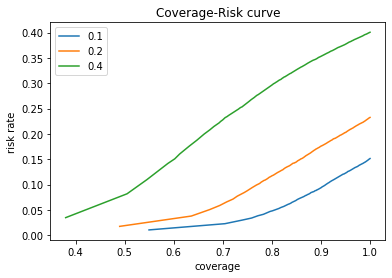

In [ ]:
kappa, residuals = evaluate(model, cifar_svnh_91_loader)
# print(kappa)
plot_cr(kappa, residuals,0.1,dir_name + 'cr_vgg16_dnn_nr_{}_epoch_{}.png'.format(noise_level, epoches))
kappa, residuals = evaluate(model, cifar_svnh_82_loader)
plot_cr(kappa, residuals,0.2, dir_name + 'cr_vgg16_dnn_nr_{}_epoch_{}.png'.format(noise_level, epoches))
kappa, residuals = evaluate(model, cifar_svnh_64_loader)
plot_cr(kappa, residuals,0.4, dir_name + 'cr_vgg16_dnn_nr_{}_epoch_{}.png'.format(noise_level, epoches))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:381: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 84.59 %
Accuracy of the network on the 10000 test images: 76.67 %
Accuracy of the network on the 10000 test images: 60.23 %


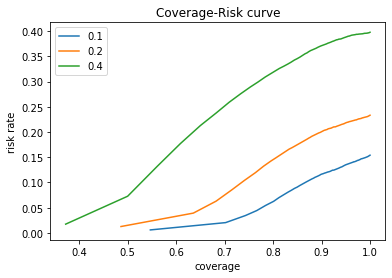

In [ ]:
kappa, residuals = evaluate(model, cifar_fake_91_loader)
# print(kappa)
plot_cr(kappa, residuals,0.1, dir_name + 'cr_vgg16_dnn_nr_{}_epoch_{}.png'.format(noise_level, epoches))
kappa, residuals = evaluate(model, cifar_fake_82_loader)
plot_cr(kappa, residuals,0.2, dir_name + 'cr_vgg16_dnn_nr_{}_epoch_{}.png'.format(noise_level, epoches))
kappa, residuals = evaluate(model, cifar_fake_64_loader)
plot_cr(kappa, residuals,0.4, dir_name + 'cr_vgg16_dnn_nr_{}_epoch_{}.png'.format(noise_level, epoches))